In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
import math
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch import optim
torch.manual_seed(55)
import pickle
from sklearn.linear_model import LogisticRegression
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
training_batch = np.empty((4),dtype=object)
val_batch = np.empty((1),dtype=object)
test_batch = np.empty((1),dtype=object)

In [3]:
#Taking directories of cifar 10 data
dir1= '/content/drive/My Drive/cifar-10-batches-py/batches.meta' 
dir2='/content/drive/My Drive/cifar-10-batches-py/data_batch_1' 
dir3='/content/drive/My Drive/cifar-10-batches-py/data_batch_2'  
dir4='/content/drive/My Drive/cifar-10-batches-py/data_batch_3'
dir5='/content/drive/My Drive/cifar-10-batches-py/data_batch_4'
dir6='/content/drive/My Drive/cifar-10-batches-py/data_batch_5' 
dir7='/content/drive/My Drive/cifar-10-batches-py/test_batch'
path = "/content/drive/My Drive/cifar-10-batches-py"

In [4]:
with open(dir2, "rb") as fo:
        training_batch[0] = pickle.load(fo,encoding="bytes")  #pickle.load() reads the pickled byte stream of one or more python objects from a file object
with open(dir3, "rb") as fo:
        training_batch[1] = pickle.load(fo,encoding="bytes")
with open(dir4, "rb") as fo:
        training_batch[2] = pickle.load(fo,encoding="bytes")
with open(dir5, "rb") as fo:
        training_batch[3] = pickle.load(fo,encoding="bytes")
with open(dir6, "rb") as fo:
       val_batch[0] = pickle.load(fo,encoding="bytes")
with open(dir7, "rb") as fo:
       test_batch[0] = pickle.load(fo,encoding="bytes")
with open(dir1, "rb") as fo:
       meta_data = pickle.load(fo,encoding="bytes")


In [5]:
#Checking meta data label names
meta_data[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [6]:
training_batch[0][b'data'].shape   #Checking training batch shape

(10000, 3072)

In [7]:
#Defining Custom Data loader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,batch,b_type,transform):
        self.transform = transform
        if b_type == "train":
            self.data = np.concatenate((batch[0][b'data'],batch[1][b'data'],
                                        batch[2][b'data'],batch[3][b'data']),axis=0) #If it is train data concetenating first four batches
            self.label = np.concatenate((batch[0][b'labels'],batch[1][b'labels'],
                                        batch[2][b'labels'],batch[3][b'labels']))
        #If it is not train data then take one batch   
        else:
            self.data = batch[0][b'data']  
            self.label = batch[0][b'labels']
           
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,index):
        label = self.label[index]
        image_data = self.data[index]
        # Converting (3072,) array to (3,32,32)
        image_r = image_data[:1024].reshape(32,32)
        image_g = image_data[1024:2048].reshape(32,32)
        image_b = image_data[2048:].reshape(32,32)
        image = np.array([image_r,image_g,image_b])
         # Changing the batch dimension to the last dimension
        image = np.transpose(image,(1,2,0))
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    

In [8]:
#Doing  Data augmentation
data_transformers = {"train": transforms.Compose([transforms.ToPILImage(),
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor()]),
            "test":transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize(224),
                                       transforms.ToTensor()])}
# Defining training, test and validation dataset by calling CustomDataset 
train_data = CustomDataset(training_batch,"train",transform=data_transformers["test"])
val_data = CustomDataset(val_batch,"validation",transform=data_transformers["test"])
test_data = CustomDataset(test_batch,"test",transform=data_transformers["test"])
#Data Loader
train_dataloader = DataLoader(train_data,batch_size=500,shuffle=False)
val_dataloader = DataLoader(val_data,batch_size=500,shuffle=False)
test_dataloader = DataLoader(test_data,batch_size=500,shuffle=False)

In [11]:
#Alexnet Model
AlexNet = models.alexnet(pretrained=False)
AlexNet.load_state_dict(torch.load("/content/drive/My Drive/alexnet-owt-7be5be79.pth"))
AlexNet.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

*** prediction and true label finding***

In [12]:
    model=AlexNet
    valloader=test_dataloader
    loss_fn="loss"
    device="cuda"
    
    model.eval()
    predictions_count = np.zeros(1000)
    predictionss = []
    true_labels = []
    true_labels_count = np.zeros(10)
    with torch.no_grad():
        for batch, (images,labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            images = images.float() # weights are float , so convering images to float
            labels = labels.type(torch.long)
            outputs = model(images)
            _, predictions = torch.max(outputs.data,1)
            for i in predictions:
                predictions_count[i] += 1
            for i in labels:
                true_labels_count[i] += 1
            predictionss.extend(predictions.to("cpu"))
            true_labels.extend(labels.to("cpu"))

In [13]:
# calculate top predictions
top_predictionss =  predictions_count.argsort()[-10:][::-1]
CountTop_predictions = predictions_count[top_predictionss]
print(top_predictionss)
print(CountTop_predictions)

[901 680  80 351 190 556 111 653 813 712]
[3023. 2226.  695.  501.  410.  343.  299.  297.  173.  172.]


In [14]:
# Read from imagenet classes text file
with open('/content/drive/My Drive/imagenet_classes.txt') as f:
    imgnet_labels = [line.strip() for line in f.readlines()]

In [15]:
top_classes = []
for i in top_predictionss:
    top_classes.append(imgnet_labels[i])

top_classes

['901, whiskey_jug',
 '680, nipple',
 '80, black_grouse',
 '351, hartebeest',
 '190, Sealyham_terrier',
 '556, fire_screen',
 '111, nematode',
 '653, milk_can',
 '813, spatula',
 '712, Petri_dish']

In [16]:
predictions_np = np.array(predictionss)
truelabel_np = np.array(true_labels)

# Constructing a *Confusion Matrix* that relates the CIFAR10 classes with the 10 most frequent classes from ImageNet predicted by the model

In [17]:

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

predict_class = [imgnet_labels[i] for i in predictions_np]  

indices = [] 

for idx,each in enumerate(predict_class):
    if each in top_classes:
        indices.append(idx)


predict_class = [top_classes.index(predict_class[i]) for i in indices] 

true_class = [truelabel_np[i] for i in indices] 

Matrix= confusion_matrix(true_class, predict_class)
# Retrieving top predicted classes names
top_classes[0].split()[1]
top_classes_names = [top_classes[i].split()[1] for i in np.arange(len(top_classes))]

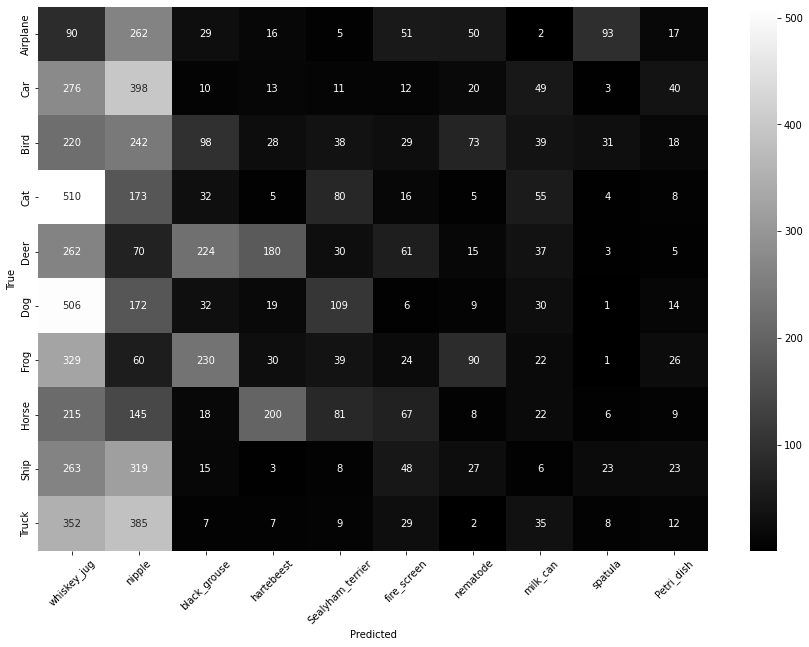

In [19]:
fig = plt.figure(figsize=(15,10))
ax= plt.subplot()
sn.heatmap(Matrix,cmap="gray",annot=True, ax = ax, fmt = 'g');

ax.set_xlabel('Predicted')
plt.xticks(rotation=45)
ax.xaxis.set_ticklabels(top_classes_names)
ax.xaxis.tick_bottom()
ax.set_ylabel('True')
cifar_classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
ax.yaxis.set_ticklabels(cifar_classes)

plt.savefig('cm.png')
plt.show()


**Training a logistic regression by using output from fc6 - **

In [20]:
AlexNet_1 = models.alexnet(pretrained=False)
AlexNet_1.load_state_dict(torch.load("/content/drive/My Drive/alexnet-owt-7be5be79.pth"))
AlexNet_1.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
AlexNet_1.classifier = nn.Sequential(
    nn.Dropout(0.5,False),
    nn.Linear(9216,4096,True)
)
print(AlexNet_1)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#Getting output for training batches

In [22]:
    AlexNet_1.cuda()
    model=AlexNet_1
    valloader=train_dataloader
    device="cuda"
    progress_bar = tqdm(range(len(valloader)))
    model.eval()
    #  labels_list for keeping track of the labels
    labels_list = [] 
    # outputs_list for keeping the output of features of lienar layer fc6
    outputs_list = [] 
    with torch.no_grad():
        for batch, (images,labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            labels = labels.type(torch.long)
            outputs = model(images)
            outputs = outputs.cpu().detach().numpy()
            labels_list.extend(labels.to("cpu"))
            outputs_list.extend(outputs)
            progress_bar.update(1)

    labels_list = np.array(labels_list)
    outputs_list = np.array(outputs_list)
    train_outputs=outputs_list
    train_labels=labels_list
 


  0%|          | 0/80 [00:00<?, ?it/s]

In [23]:
print(train_labels[0])
print(train_outputs[0])

6
[-0.50466204  0.01312917 -0.17883444 ...  0.21389395  0.06622521
 -0.18691981]


#Getting output for validation batches - Using the same function as train batch

In [24]:
    AlexNet_1.cuda()
    model=AlexNet_1
    valloader=val_dataloader
    device="cuda"
    progress_bar = tqdm(range(len(valloader)))
    model.eval()
    
    labels_list = [] 
    outputs_list = [] 
    with torch.no_grad():
        for batch, (images,labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            labels = labels.type(torch.long)
            outputs = model(images)
            outputs = outputs.cpu().detach().numpy()
            labels_list.extend(labels.to("cpu"))
            outputs_list.extend(outputs)
            progress_bar.update(1)

    labels_list = np.array(labels_list)
    outputs_list = np.array(outputs_list)
    val_outputs=outputs_list
    val_labels=labels_list 

  0%|          | 0/20 [00:00<?, ?it/s]

#Getting output for test batches - Using the same function as train batch

In [25]:
    AlexNet_1.cuda()
    model=AlexNet_1
    valloader=test_dataloader
    device="cuda"
    progress_bar = tqdm(range(len(valloader)))
    model.eval()
    
    labels_list = [] 
    outputs_list = []
    with torch.no_grad():
        for batch, (images,labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            labels = labels.type(torch.long) 
            outputs = model(images)
            outputs = outputs.cpu().detach().numpy()
            labels_list.extend(labels.to("cpu"))
            outputs_list.extend(outputs)
            progress_bar.update(1)

    labels_list = np.array(labels_list)
    outputs_list = np.array(outputs_list)
    test_outputs=outputs_list
    test_labels=labels_list 


  0%|          | 0/20 [00:00<?, ?it/s]

**logistic regression**

In [26]:
logisticRegresson = LogisticRegression(penalty="l2",verbose = 2, fit_intercept=True,
                                    multi_class="multinomial",n_jobs=6,random_state=1)


In [27]:
logisticRegresson.fit(train_outputs,train_labels) # fit the model

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:  2.6min finished


LogisticRegression(multi_class='multinomial', n_jobs=6, random_state=1,
                   verbose=2)

# Calculating training accuracy

In [28]:
train_accuracy = logisticRegresson.score(train_outputs,train_labels) 
print("Training Accuracy: ",train_accuracy*100,"%")

Training Accuracy:  83.3775 %


# Calculating validation accuracy

In [29]:
val_accuracy = logisticRegresson.score(val_outputs,val_labels) 
print("Validaction Accuracy: ", val_accuracy*100,"%")


Validaction Accuracy:  77.14999999999999 %


 # Calculating test accuracy

In [30]:
test_accuracy = logisticRegresson.score(test_outputs,test_labels)
print("Test Accuracy: ", test_accuracy*100,"%")


Test Accuracy:  76.55999999999999 %


**Training a logistic regression by using output from fc7  **

In [41]:
AlexNet2 = models.alexnet(pretrained=False)
AlexNet2.load_state_dict(torch.load("/content/drive/My Drive/alexnet-owt-7be5be79.pth"))
AlexNet2.classifier = nn.Sequential(
    nn.Dropout(0.5,False),
    nn.Linear(9216,4096,True),
    nn.ReLU(True),
    nn.Dropout(0.5,False),
    nn.Linear(4096,4096,True)   
)
print(AlexNet2)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#Getting output for training batch

In [42]:
    AlexNet2.cuda()
    model=AlexNet2
    valloader=train_dataloader
    device="cuda"
    progress_bar = tqdm(range(len(valloader)))
    model.eval()
   #  labels_list for keeping track of the labels
    labels_list = []
   # outputs_list for keeping the output of features of lienar layer fc7
    outputs_list = []
    with torch.no_grad():
        for batch, (images,labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            labels = labels.type(torch.long)
            outputs = model(images)
            outputs = outputs.cpu().detach().numpy()
            labels_list.extend(labels.to("cpu"))
            outputs_list.extend(outputs)
            progress_bar.update(1)

    labels_list = np.array(labels_list)
    outputs_list = np.array(outputs_list)
    train_outputs2=outputs_list
    train_labels2=labels_list 


  0%|          | 0/80 [00:00<?, ?it/s]

#Getting output for validation batch - Using the same function as train batch

In [43]:
    AlexNet2.cuda()
    model=AlexNet2
    valloader=val_dataloader
    device="cuda"
    progress_bar = tqdm(range(len(valloader)))
    model.eval()
    
    labels_list = []
    outputs_list = []
    with torch.no_grad():
        for batch, (images,labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            labels = labels.type(torch.long)
            outputs = model(images)
            outputs = outputs.cpu().detach().numpy()
            labels_list.extend(labels.to("cpu"))
            outputs_list.extend(outputs)
            progress_bar.update(1)

    labels_list = np.array(labels_list)
    outputs_list = np.array(outputs_list)
    val_outputs2=outputs_list
    val_labels2=labels_list 


  0%|          | 0/20 [00:00<?, ?it/s]

#Getting output for test batch -Using the same function as train batch

In [44]:
    AlexNet2.cuda()
    model=AlexNet2
    valloader=test_dataloader
    device="cuda"
    progress_bar = tqdm(range(len(valloader)))
    model.eval()
    
    labels_list = []
    outputs_list = []
    with torch.no_grad():
        for batch, (images,labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            labels = labels.type(torch.long)
            outputs = model(images)
            outputs = outputs.cpu().detach().numpy()
            labels_list.extend(labels.to("cpu"))
            outputs_list.extend(outputs)
            progress_bar.update(1)

    labels_list = np.array(labels_list)
    outputs_list = np.array(outputs_list)
    print("shape of labels_list: ", labels_list.shape)
    print("shape of outputs_list: ",outputs_list.shape)
    test_outputs2=outputs_list
    test_labels2=labels_list 


  0%|          | 0/20 [00:00<?, ?it/s]

shape of labels_list:  (10000,)
shape of outputs_list:  (10000, 4096)


**logistic regression**

In [45]:
from sklearn.linear_model import LogisticRegression
logisticRegresson2 = LogisticRegression(penalty="l2",verbose = 2, fit_intercept=True,
                                    multi_class="multinomial",n_jobs=6,random_state=1)

In [46]:
logisticRegresson2.fit(train_outputs2,train_labels2) # fit the model

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:  5.8min finished


LogisticRegression(multi_class='multinomial', n_jobs=6, random_state=1,
                   verbose=2)

**Training Accuracy**

In [38]:
train_accuracy2 = logisticRegresson2.score(train_outputs2,train_labels2)
print(train_accuracy2*100,"%")

80.9525 %


**Validation Accuracy**

In [39]:
val_accuracy2 = logisticRegresson2.score(val_outputs2,val_labels2)
print(val_accuracy2*100,"%")

75.1 %


**Finding Test Accuracy**

In [40]:
test_accuracy2 = logisticRegresson2.score(test_outputs2,test_labels2)
print(test_accuracy2*100,"%")

74.7 %


**Comparison and Discussion between Question C and D:**
After using the output of fc6 layer, the accuracy are as following. Training accuracy-83.38%, Validation Accuracy-77.15%, Test Accuracy- 76.56%. After using the output of fc7 layer, the accuracy are as following. Training accuracy-80.95%, Validation Accuracy- 75.1%, Test Accuracy-74.7%. So, we can see that the test accuracy is better when we used the output of fc6 layer. Also In case of, training and validation, the accuracy was better when we used the output of fc6 layer instead of fc7 layer.